<a href="https://colab.research.google.com/github/sensationalspace/colab/blob/main/Getting_Started_with_Nucleus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Finetuning tutorial with Scale Nucleus

In this tutorial, we'll finetune a pre-trained [Faster R-CNN](https://arxiv.org/abs/1506.01497) model on the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/) which contains 170 images with 423 instances of pedestrians.

After training the Faster R-CNN model, we'll upload our data to Nucleus, where we'll be able to visualize model performance and diagnose failure cases.


# Installing Dependencies


We need to install `pycocotools`, a library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

Then, we'll install the Nucleus python client, which we'll use to upload data to the Nucleus platform.

In [1]:
%%shell
pip install cython
# Install pycocotools, the version by default in Colab
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
pip install -U scale-nucleus==0.1.25

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-q4nef_5m
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-q4nef_5m
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375550 sha256=354edb7e7b01e58ae4b1ff67f5768b62607d6d1d86a97ec242394123be10c994
  Stored in directory: /tmp/pip-ephem-wheel-cache-labflkvd/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.7
    Uninstalling pycocotools-2.0.7:
      Successfully uninstalled pycocotools-2.0.7


Import some helper functions from pytorch/vision repo to simplify training and evaluation.

In [2]:
%%shell
# Download TorchVision repo to use some files from references/detection
git clone https://github.com/sasha-scale/vision.git
cd vision

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../
cp references/detection/demo_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 9998, done.
remote: Total 9998 (delta 0), reused 0 (delta 0), pack-reused 9998
Receiving objects: 100% (9998/9998), 11.47 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (6892/6892), done.


In [3]:
import os
import json
import numpy as np
import torch
import torchvision
import torch.utils.data
from typing import List, Dict
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import ImageDraw, Image

# Custom helpers
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from demo_utils import *

# Nucleus library
import nucleus
from nucleus import DatasetItem, BoxAnnotation, BoxPrediction

ModuleNotFoundError: No module named 'torch._six'

# Getting an API key
You'll need an API key before continuing with this tutorial.


1.   [Sign up](https://dashboard.scale.com/signup) for an account
2.   Add payment information to get a live API key
3.   Paste your API key below

Documentation for the Nucleus Library can be found
[here](https://dashboard.scale.com/nucleus/docs/api)



In [5]:
API_KEY = '' #YOUR API KEY HERE
nucleus = nucleus.NucleusClient(API_KEY, use_notebook=True)

NameError: name 'nucleus' is not defined

# Download Dataset
In this tutorial, we'll be using the PennFudan dataset, an opensource image dataset for pedestrian detection and segmentation.

In [ ]:
%%shell
# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2021-10-19 04:31:12--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  69.5MB/s    in 0.7s    

2021-10-19 04:31:13 (69.5 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-10-19 04:31:13--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-10-19 04:31:13--
Total wall clock time: 0.9s
Downloaded: 1 files, 51M in 0.7s (69.5 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

# Data Exploration

Here's how our dataset is structured - we have ground truth labels for bounding boxes as well as segmentation masks for pedestrians
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
    ...
  Annotation/
    FudanPed00001.txt
    FudanPed00002.txt
    FudanPed00003.txt
    FudanPed00004.txt
```

Let's visualize an image with its ground truth bounding boxes


In [ ]:
# init some global constants
DATASET_ROOT_DIR = 'PennFudanPed'
IMG_DIR = f'{DATASET_ROOT_DIR}/PNGImages'
ANNOTATIONS_DIR = f'{DATASET_ROOT_DIR}/PedMasks'
PEDESTRIAN_LABEL = 'pedestrian'

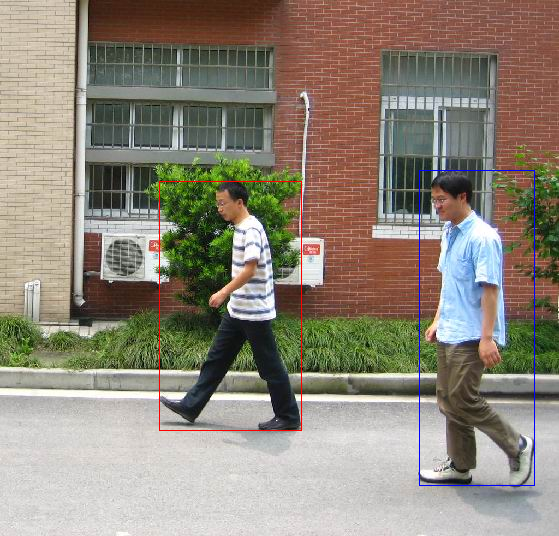

In [ ]:
img = draw_bounding_boxes(
    "PennFudanPed/PedMasks/FudanPed00001_mask.png",
    "PennFudanPed/PNGImages/FudanPed00001.png",
)
img

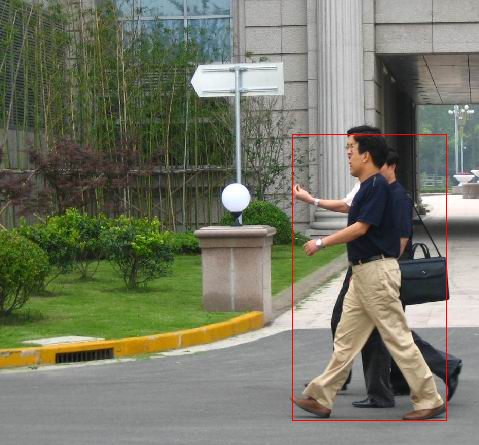

In [ ]:
img = draw_bounding_boxes(
    "PennFudanPed/PedMasks/FudanPed00003_mask.png",
    "PennFudanPed/PNGImages/FudanPed00003.png",
)
img

# <font color = "blue"> Create new Dataset in Scale Nucleus

In [ ]:
nucleus_dataset = nucleus.create_dataset("PennFudan")
DATASET_ID = nucleus_dataset.info()['dataset_id'] # Save unique ID for future use
nucleus_dataset.info()

{'annotation_metadata_schema': None,
 'dataset_id': 'ds_c5qnth207yng09sq8h4g',
 'item_metadata_schema': None,
 'length': 0,
 'model_run_ids': [],
 'name': 'gm_lidar_test',
 'slice_ids': []}

### <font color = "blue"> Upload dataset items

In [ ]:
def format_img_data_for_upload(img_dir: str):
    """Instantiates a Nucleus DatasetItem for all images in the PennFudan dataset.

    Parameters
    ----------
    img_dir : str
        The filepath to the image directory

    Returns
    -------
    List[DatasetItem]
        A list of DatasetItem that can be uploaded via the Nucleus API
    """
    img_list = []
    for img_filename in os.listdir(img_dir):
        img_id = img_filename.split('.')[0]
        item = DatasetItem(
            image_location=os.path.join(img_dir, img_filename),
            reference_id=img_id
        )
        img_list.append(item)
    return img_list

img_list = format_img_data_for_upload(IMG_DIR)
print("Example payload format for uploading local image to Nucleus: ")
print(img_list[0])

Example payload format for uploading local image to Nucleus: 
DatasetItem(image_location='PennFudanPed/PNGImages/FudanPed00005.png', reference_id='FudanPed00005', metadata=None, pointcloud_location=None, upload_to_scale=True)


In [ ]:
response = nucleus_dataset.append(img_list)
response.json()

Local file batches:   0%|          | 0/9 [00:00<?, ?it/s]

{'dataset_id': 'ds_c5q4m6r32gag0f15e6p0',
 'ignored_items': 170,
 'new_items': 0,
 'updated_items': 0,
 'upload_errors': 0}

In [ ]:
#Let's confirm these dataset_items were uploaded correctly
nucleus_dataset.info()

{'annotation_metadata_schema': None,
 'dataset_id': 'ds_c5q4m6r32gag0f15e6p0',
 'item_metadata_schema': None,
 'length': 170,
 'model_run_ids': [],
 'name': 'PennFudan',
 'slice_ids': []}

### <font color = "blue"> Upload annotations

Now that we have our images uploaded, the next step is to upload the 2D bounding box annotations.

Note: Will need to reformat annotations from (xmin, ymin, xmax, ymax) to (xmin, ymin, width, height)

In [ ]:
def format_annotations_for_upload(annotations_dir: str):
    """Instantiates a Nucleus BoxAnnotation for all ground truth annotations
    in the PennFudan dataset.

    Parameters
    ----------
    annotations_dir : str
        The filepath to the directory storing mask annotations

    Returns
    -------
    List[BoxAnnotation]
        A list of BoxAnnotation items that can be uploaded via the Nucleus API
    """
    annotation_list = []
    for mask_filename in os.listdir(annotations_dir):
        img_filename = mask_filename.split(".")[0][:-5]
        mask = Image.open(os.path.join(annotations_dir, mask_filename))
        mask = np.array(mask)
        boxes = get_boxes(
            mask, use_height_width_format=True
        )
        for i in range(len(boxes)):
            x = int(boxes[i][0])
            y = int(boxes[i][1])
            width = int(boxes[i][2])
            height = int(boxes[i][3])
            annotation = BoxAnnotation(
                label=PEDESTRIAN_LABEL,
                x=x,
                y=y,
                width=width,
                height=height,
                reference_id=img_filename
            )
            annotation_list.append(annotation)
    return annotation_list

In [ ]:
annotations = format_annotations_for_upload(ANNOTATIONS_DIR)
print("Example GT Annotation format: ", annotations[0])
response = nucleus_dataset.annotate(annotations)
response

Example GT Annotation format:  BoxAnnotation(label='pedestrian', x=338, y=98, width=169, height=282, reference_id='FudanPed00020', annotation_id='pedestrian-338-98-169-282-FudanPed00020', metadata={})


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'annotations_ignored': 0,
 'annotations_processed': 423,
 'dataset_id': 'ds_c5q4m6r32gag0f15e6p0'}

In [ ]:
# You can visit this URL to see what the ground truth annotations look like in the Nucleus dashboard
print("https://dashboard.scale.com/nucleus/{}".format(DATASET_ID))

https://dashboard.scale.com/nucleus/ds_c5q4m6r32gag0f15e6p0


Pretty cool! Now let's work on a model, fit it to our dataset, and upload it's predictions

## Defining the Dataloader

For brevity, we've omitted the Dataloader definition here, instead importing it from `vision/references/detection/demo_utils.py`. If you're really interested in looking into the details, feel free to check out the repo on GitHub!



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `references/detection` that we have just copied:


In [ ]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
DATASET_ROOT_DIR

'PennFudanPed'

In [ ]:
# Set a random seed for reproducibility
torch.manual_seed(1)
N_TEST = 50

# use our dataset and defined transformations
dataset_train_all = PennFudanDataset(DATASET_ROOT_DIR, get_transform(train=True))
dataset_test_all = PennFudanDataset(DATASET_ROOT_DIR, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset_train_all)).tolist()
dataset_train = torch.utils.data.Subset(dataset_train_all, indices[:-N_TEST])
dataset_test = torch.utils.data.Subset(dataset_test_all, indices[-N_TEST:])

In [ ]:
# define training and test data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

### Use Nucleus slices to track the training and test datasets

In [ ]:
def get_slice_item_reference_ids(dataset: torch.utils.data.Subset):
    """ Given a Pytorch dataset, returns a list of reference_ids corresponding
    to the dataset's contents.

    Parameters
    ----------
    dataset : str
        A Pytorch dataset.

    Returns
    -------
    List[str]
        A list of reference_ids for items to be uploaded to a Nucleus Slice.
    """
    reference_ids = []
    for i in range(len(dataset)):
        _, _, img_file_name = dataset[i]
        ref_id = img_file_name.split(".")[0]  # remove file extension
        reference_ids.append(ref_id)
    return reference_ids

In [ ]:
train_reference_ids = get_slice_item_reference_ids(dataset_train)

slice_train = nucleus_dataset.create_slice(name='training_set', reference_ids=train_reference_ids)
slice_train.info()

{'dataset_id': 'ds_c5q4m6r32gag0f15e6p0',
 'dataset_items': [{'id': 'di_c5q4mb98x0e005r9we80',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/f23a9542-33a8-47e8-a62d-8e2f59196e4f',
   'ref_id': 'FudanPed00005',
   'upload_to_scale': True},
  {'id': 'di_c5q4mb98x0e005r9we90',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/d8b30d72-c392-4867-8832-9874153c6ce6',
   'ref_id': 'FudanPed00012',
   'upload_to_scale': True},
  {'id': 'di_c5q4mb98x0e005r9wea0',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/382f43e3-d835-49ed-9dec-56e24fa2d09e',
   'ref_id': 'FudanPed00015',
   'upload_to_scale': True},
  {'id': 'di_c5q4mb98x0e005r9weag',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/23e1fa3f-94a7-4

In [ ]:
test_reference_ids = train_reference_ids = get_slice_item_reference_ids(dataset_test)

slice_test = nucleus_dataset.create_slice(name='test_set', reference_ids=test_reference_ids)
slice_test.info()

{'dataset_id': 'ds_c5q4m6r32gag0f15e6p0',
 'dataset_items': [{'id': 'di_c5q4mb98x0e005r9we8g',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/a62e30df-d95d-44b7-8224-7461a9f55073',
   'ref_id': 'PennPed00089',
   'upload_to_scale': True},
  {'id': 'di_c5q4mb98x0e005r9we9g',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/17f326b7-c305-48ce-ab06-9accc9cf92b9',
   'ref_id': 'FudanPed00013',
   'upload_to_scale': True},
  {'id': 'di_c5q4mb98x0e005r9webg',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/9f10735d-3ffd-4516-9e74-631a4a4406f3',
   'ref_id': 'FudanPed00038',
   'upload_to_scale': True},
  {'id': 'di_c5q4mbhp5rvg09sn5ftg',
   'metadata': {},
   'original_image_url': 'https://scale-us-attachments.s3.us-west-2.amazonaws.com/scale-select/nucleus/af5c2209-e891-4a

# Train an Object Detection Model: Finetuning

We will be using [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

Since this is a small dataset, we will start with a model pretrained
on COCO and just finetune the last layer.



In [ ]:
# our dataset has two classes only - background and person
def get_model(num_classes: int = 2):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

### Putting everything together

Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_model()
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

### Test forward pass
Let's make sure we're able to do a forward pass with our untrained model and dataloader.  We expect that the predictions will be garbage!

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


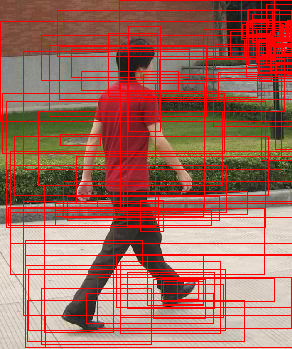

In [ ]:
#Let's confirm that our classifier does not perform well without being trained
img, _, _ = dataset_test[0]
model.eval()
with torch.no_grad():
  pred = model([img.to(device)])

draw_prediction(img, pred)

We'll train the model for 10 epochs, evaluating at the end of every epoch.

## Training loop

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:29  lr: 0.000090  loss: 1.3120 (1.3120)  loss_classifier: 0.7394 (0.7394)  loss_box_reg: 0.5075 (0.5075)  loss_objectness: 0.0512 (0.0512)  loss_rpn_box_reg: 0.0139 (0.0139)  time: 1.4971  data: 0.0669  max mem: 2113
Epoch: [0]  [20/60]  eta: 0:00:59  lr: 0.001783  loss: 0.5617 (0.7026)  loss_classifier: 0.2800 (0.3662)  loss_box_reg: 0.2668 (0.3123)  loss_objectness: 0.0117 (0.0184)  loss_rpn_box_reg: 0.0043 (0.0057)  time: 1.4817  data: 0.0353  max mem: 3564
Epoch: [0]  [40/60]  eta: 0:00:29  lr: 0.003476  loss: 0.2860 (0.5025)  loss_classifier: 0.0607 (0.2182)  loss_box_reg: 0.2190 (0.2657)  loss_objectness: 0.0015 (0.0133)  loss_rpn_box_reg: 0.0037 (0.0054)  time: 1.4369  data: 0.0382  max mem: 3564
Epoch: [0]  [59/60]  eta: 0:00:01  lr: 0.005000  loss: 0.1717 (0.3989)  loss_classifier: 0.0436 (0.1631)  loss_box_reg: 0.1150 (0.2198)  loss_objectness: 0.0006 (0.0104)  loss_rpn_box_reg: 0.0057 (0.0056)  time: 1.5201  data: 0.0376  max mem: 3564
Epoch: [

## Test on Test Set

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [ ]:
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:16  model_time: 0.3168 (0.3168)  evaluator_time: 0.0021 (0.0021)  time: 0.3275  data: 0.0081  max mem: 3567
Test:  [49/50]  eta: 0:00:00  model_time: 0.3311 (0.3270)  evaluator_time: 0.0013 (0.0017)  time: 0.3514  data: 0.0169  max mem: 3567
Test: Total time: 0:00:17 (0.3466 s / it)
Averaged stats: model_time: 0.3311 (0.3270)  evaluator_time: 0.0013 (0.0017)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ IoU

FudanPed00035.png


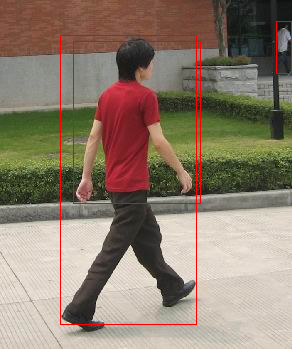

In [ ]:
img, _, img_name = dataset_test[0]
print(img_name)
with torch.no_grad():
  prediction = model([img.to(device)])

draw_prediction(img, prediction)

PennPed00072.png


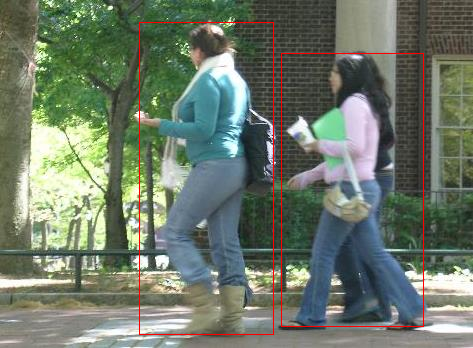

In [ ]:
img, _, img_name = dataset_test[2]
print(img_name)
with torch.no_grad():
    prediction = model([img.to(device)])

draw_prediction(img, prediction)

looks pretty good!

# Uploading Predictions to Nucleus

In [ ]:
# Predictions for entire dataset
def get_model_predictions(model, dataset):
    """Gets bounding box predictions on provided dataset, returns
    BoxPredictions that can be uplaoded to Nucleus via API

    Parameters
    ----------
    model :
        Pytorch Faster R-CNN model
    dataset :
        Dataset on which to conduct inference.

    Returns
    -------
    List[BoxPrediction]
        A list of BoxPredictions that can be uploaded to Nucleus via API.
    """
    predictions = []
    model.eval()
    for i, (img, _, img_name) in enumerate(dataset):
        pred = model([img.to(device)])
        boxes = pred[0]["boxes"].cpu().detach().numpy()
        img_id = img_name.split(".")[0]
        for box in boxes:
            (xmin, ymin, xmax, ymax) = box
            x = int(xmin)
            y = int(ymin)
            width = int(xmax - xmin)
            height = int(ymax - ymin)
            curr_pred = BoxPrediction(
                label=PEDESTRIAN_LABEL,
                x=x,
                y=y,
                width=width,
                height=height,
                reference_id=img_id
            )
            predictions.append(curr_pred)
    return predictions

preds = get_model_predictions(model, dataset_test_all)

## <font color = "blue"> Creating models in Nucleus

To create a new model, we initialize the model object with a `name`, `reference_id`, and optionally add `metadata` about our model.





In [ ]:
# Create a new model to track all of our Faster R-CNN experiments
nucleus_model = nucleus.add_model(name="Pytorch Faster R-CNN", reference_id="faster_r_cnn")
nucleus_model

Model(model_id='prj_c5q4y7gkkt000eh1qwf0', name='Pytorch Faster R-CNN', reference_id='faster_r_cnn_11', metadata=None, client=NucleusClient(api_key='live_7695c497f28f45b2b85ddd95f6c7aab6', use_notebook=True, endpoint='https://api.scale.com/v1/nucleus'))

## <font color = "blue"> Adding a model run

A model is an object that can have multiple runs - keeping it's original architecture & hyperparameters intact. Let's go ahead and add a run for the model we just created

In [ ]:
response = nucleus_dataset.upload_predictions(nucleus_model, predictions=preds)

  0%|          | 0/1 [00:00<?, ?it/s]

## <font color = "blue"> Committing a model run

Once we commit a model run, no additional predictions can be uploaded.  Commiting a model run kicks off processes to calculate overall performance metrics such as IoU

In [ ]:
nucleus_dataset.calculate_evaluation_metrics(nucleus_model)

{'model_run_id': 'run_c5q4y8hy09n0048hkybg'}

# Visualizing Performance on the Nucleus Dashboard

Finally, click the link after running the cell below. You should be able to see everything on your dashboard :)

In [ ]:
print("https://dashboard.scale.com/nucleus/{}".format(DATASET_ID))

# Sources
This notebook is adapted from the torchvision finetuning tutorial originally published here:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# Extras

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.